In [1]:
%matplotlib inline
import pandas as pd
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import math
import os
import numpy
import sys

sys.path.append("python/")

from datasets import get_dataset, bruteforce
from distance import jaccard, l2
from lsh import LSHBuilder, LSH
from main import run_single_exp
from metrics import result_prob, total_variation_dist

plt.rcParams["figure.figsize"] =(20,10)
pd.options.display.max_rows = 2000
plt.rcParams['mathtext.fontset'] = 'cm'
#plt.rcParams['font.family'] = 'cmu serif'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'


sns.set(rc={'text.usetex' : False})
sns.set_style("whitegrid")


sns.set_context('paper', font_scale=5)

df = pd.read_csv("exp-res/exp.csv").replace({
    "glove-100-angular" : "GLOVE",
    "movielens" : "MovieLens",
    "lastfm" : "LastFM",
    "sift-128-euclidean" : "SIFT",
    "mnist-784-euclidean" : "MNIST",
    "weighted_uniform": "weighted uniform",
    "approx_degree": "approx. degree",
    "opt" : "exact degree",
})

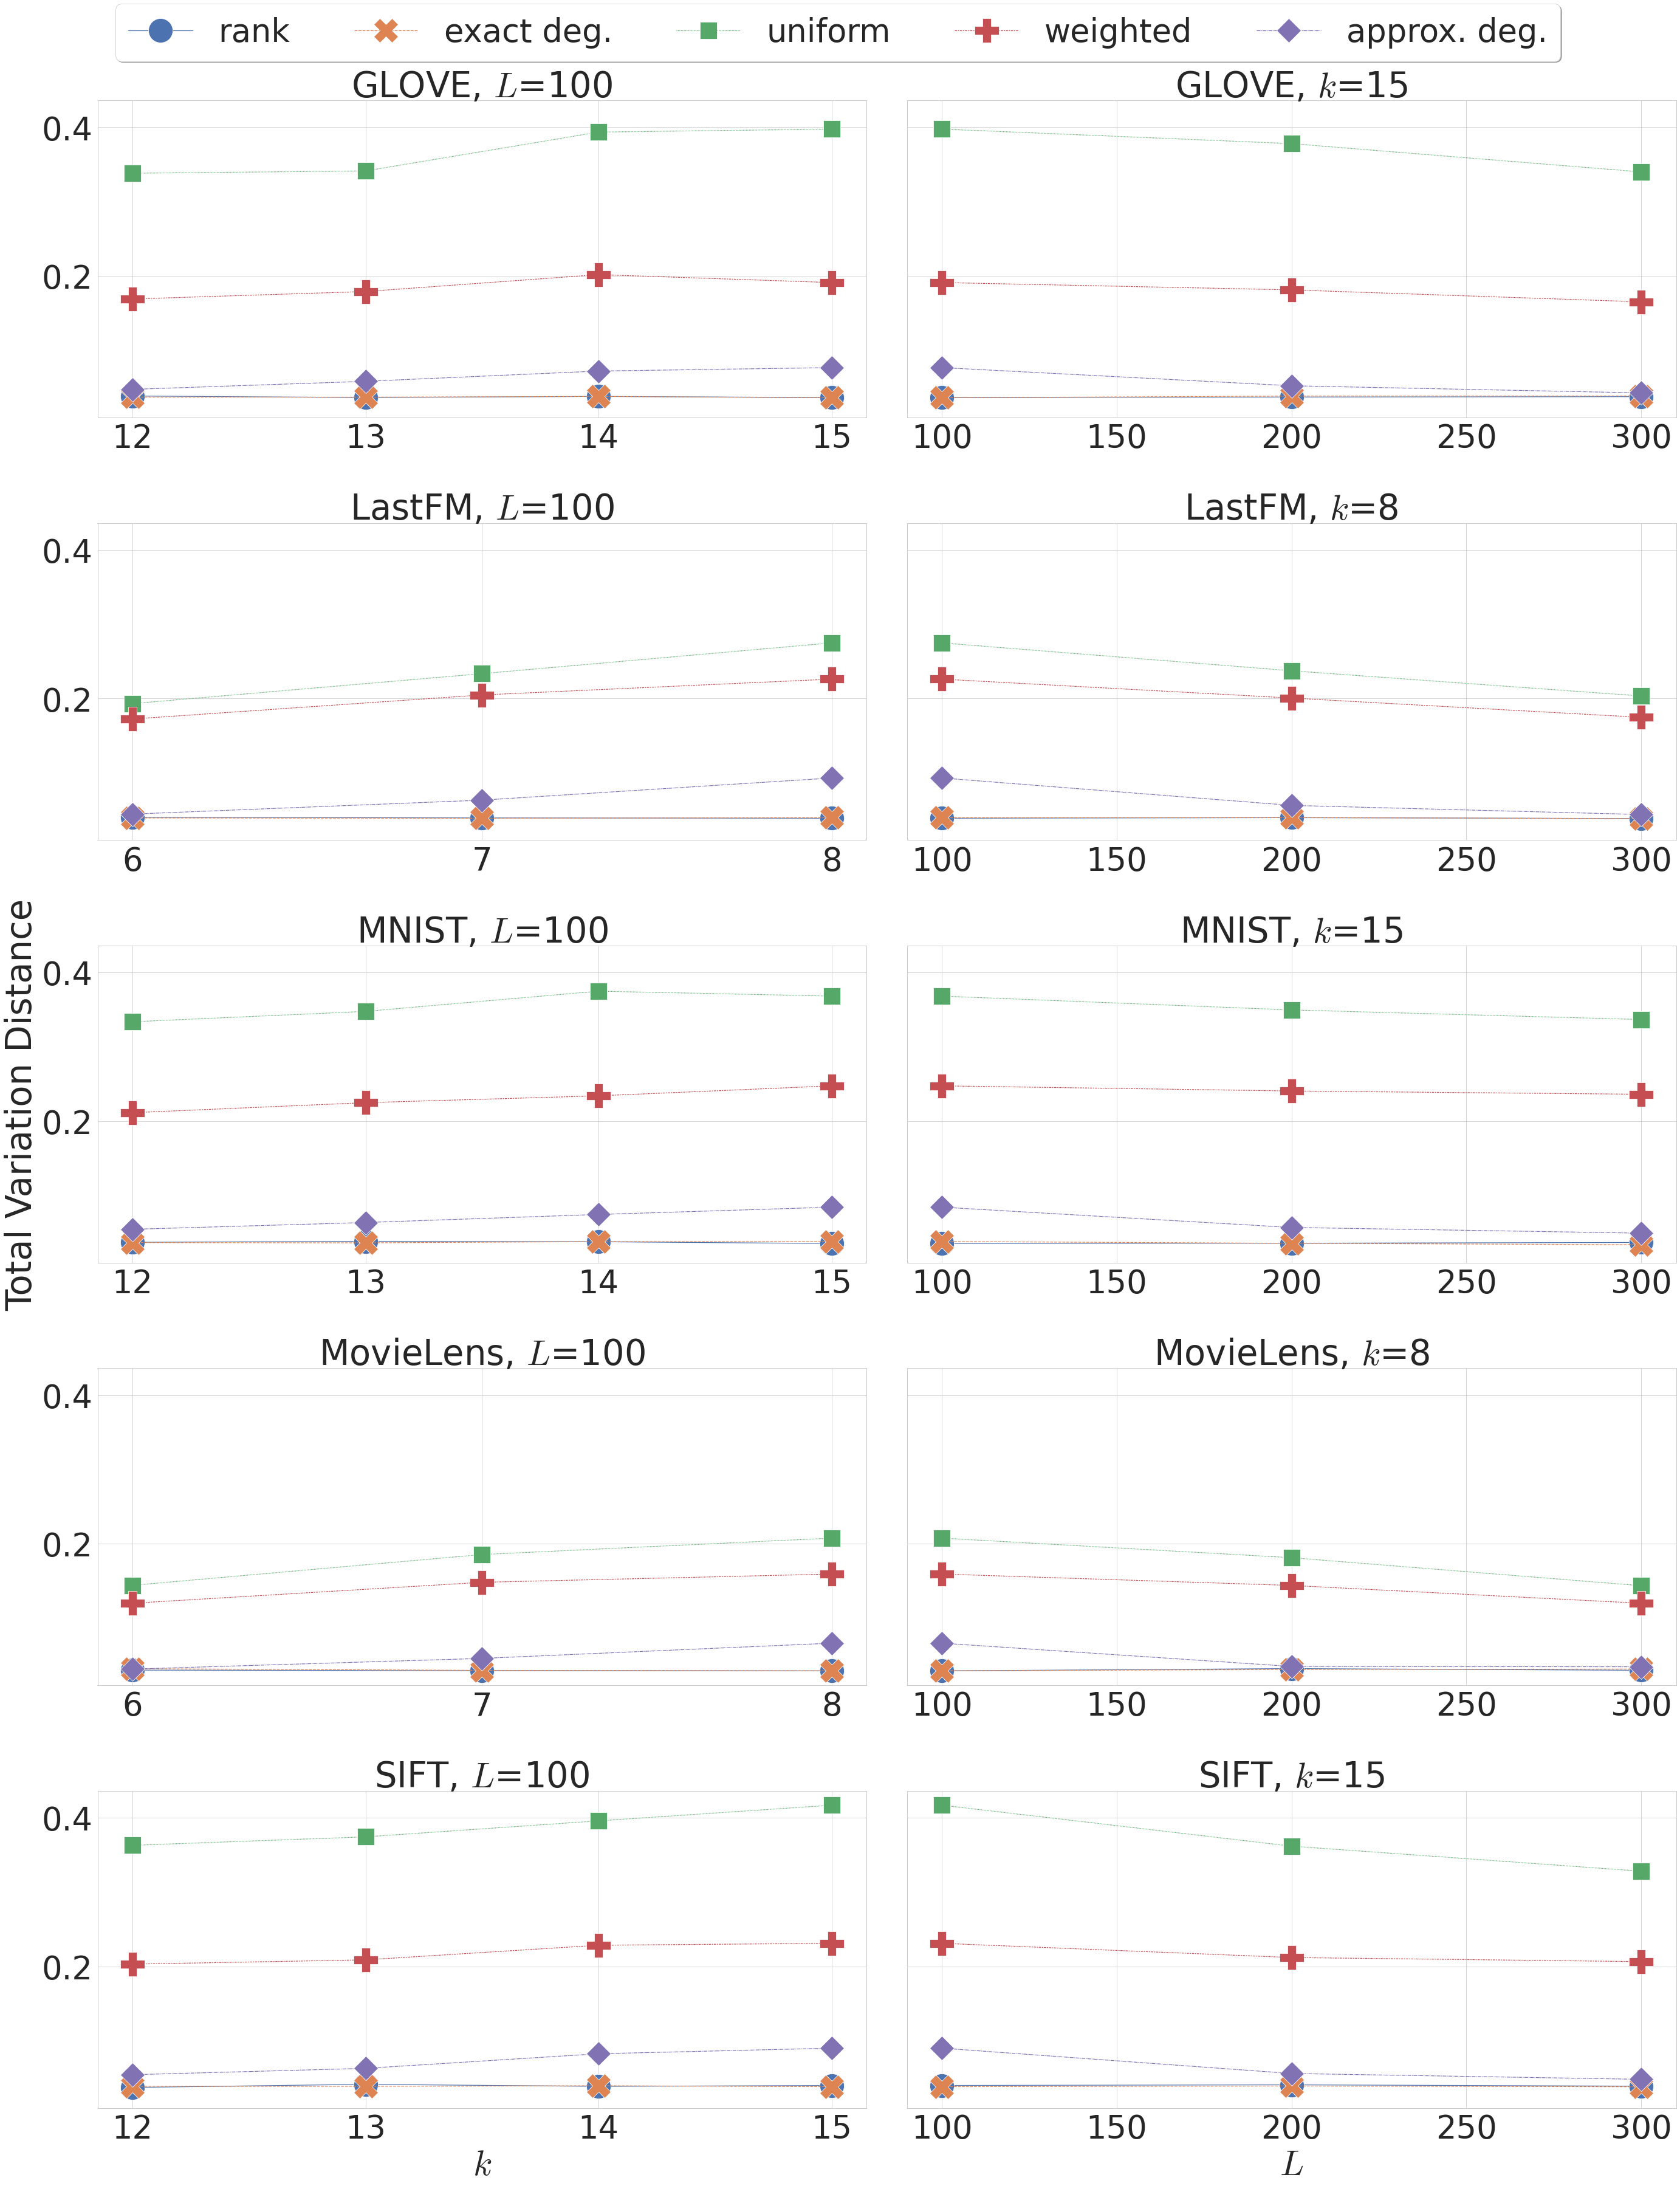

In [21]:
plt.rcParams["figure.figsize"] =(40,50)
sns.set_context('paper', font_scale=6)
fig, axs = plt.subplots(5, 2, sharey=True, sharex=False)
for i, ds in enumerate(sorted(set(df.dataset))):
    for k in set(df[df.dataset==ds].k):
        if len(set(df[(df.dataset==ds) & (df.k == k)].L.values)) > 1:
            #plt.title(f"{ds}, k={k}")
            axs[i,1].set_title(f"{ds}, $k$={k}")
            sns.lineplot(ax=axs[i,1], data=df[(df.k == k) & (df.dataset == ds)], x="L", y="tvd",style="method", hue="method", markers=True, ms=40, legend=False)

for i, ds in enumerate(sorted(set(df.dataset))):
    for L in set(df[df.dataset==ds].L):
        if len(set(df[(df.dataset==ds) & (df.L == L)].k.values)) > 1:
            #plt.title(f"{ds}, k={k}")
            axs[i,0].set_title(f"{ds}, $L$={L}")
            sns.lineplot(ax=axs[i,0], data=df[(df.L == L) & (df.dataset == ds)], x="k", y="tvd",style="method", hue="method", markers=True, ms=40, legend=False)#(i == 1))#legend=(i == 2))
            #axs[i].set_xticklabels(map(int, set(df[(df.dataset==ds) & (df.L == L)].k.values)))
            axs[i,0].xaxis.set_major_locator(MaxNLocator(integer=True))


for ax in axs.flat:
    ax.set(xlabel="", ylabel="")

axs[2,0].set(ylabel='Total Variation Distance')
axs[4,1].set(xlabel='$L$')
axs[4,0].set(xlabel='$k$')

#plt.show()
#axs[1,0].legend(ncol=5)
fig.legend(["rank", "exact deg.", "uniform", "weighted", "approx. deg."], bbox_to_anchor=(0.92, 1.02), ncol=5,shadow=True)
plt.tight_layout()
plt.savefig("plots/tvd.pdf",  bbox_inches="tight")

# Discussion of b_cr/b_r term on real-world datasets

In [27]:
def ratio_plot(ds_name, distance_fn, rs, cs):
    plt.rcParams["figure.figsize"] =(20,10)
    sns.set_context('paper', font_scale=2.5)
    data, queries, _, _ = get_dataset(ds_name)
    groundtruth = bruteforce(data, queries, distance_fn)

    ball_df = pd.DataFrame(data={'r' : [], 'c' : [], 'br' : [], 'bcr' :[], 'i' : [] })

    for r in rs:
        for c in cs:
            for i in range(len(groundtruth)):
                if distance_fn == l2:
                    b_r = len([1 for p in groundtruth[i] if distance_fn(data[p], queries[i]) <= r])
                    b_cr = len([1 for p in groundtruth[i] if distance_fn(data[p], queries[i]) <= r * c])
                elif distance_fn == jaccard:
                    b_r = len([1 for p in groundtruth[i] if distance_fn(data[p], queries[i]) >= r])
                    b_cr = len([1 for p in groundtruth[i] if distance_fn(data[p], queries[i]) >= r * c])
                ball_df = ball_df.append({'r': r, 'c' : c, 'br': b_r, 'bcr' : b_cr, 'i' : i}, ignore_index=True)
                
                
    ball_grouped_df = ball_df.groupby(['r', 'c']).sum().reset_index()
    ball_grouped_df['rel'] = ball_grouped_df[['br', 'bcr']].apply(lambda x:  x[1] / x[0], axis=1)
    sns.catplot(data=ball_grouped_df[['r', 'c', 'rel']].round(2).rename(columns={'r': '$r$', 'c': '$c$', 'rel' : '$b_{cr} / b_r$'}),x='$c$', y='$b_{cr} / b_r$', kind='bar', col='$r$')
    plt.savefig(f"plots/{ds_name}_ratio_plot.pdf")

def ratio_table(ds_name, distance_fn, rs, cs):
    plt.rcParams["figure.figsize"] =(20,10)
    sns.set_context('paper', font_scale=2.5)
    data, queries, _, _ = get_dataset(ds_name)
    groundtruth = bruteforce(data, queries, distance_fn)

    ball_df = pd.DataFrame(data={'r' : [], 'c' : [], 'br' : [], 'bcr' :[], 'i' : [] })

    for r in rs:
        for c in cs:
            for i in range(len(groundtruth)):
                if distance_fn == l2:
                    b_r = len([1 for p in groundtruth[i] if distance_fn(data[p], queries[i]) <= r])
                    b_cr = len([1 for p in groundtruth[i] if distance_fn(data[p], queries[i]) <= r * c])
                elif distance_fn == jaccard:
                    b_r = len([1 for p in groundtruth[i] if distance_fn(data[p], queries[i]) >= r])
                    b_cr = len([1 for p in groundtruth[i] if distance_fn(data[p], queries[i]) >= r * c])
                ball_df = ball_df.append({'r': r, 'c' : c, 'br': b_r, 'bcr' : b_cr, 'i' : i}, ignore_index=True)
                
                
    ball_grouped_df = ball_df.groupby(['r', 'c']).sum().reset_index()
    ball_grouped_df['rel'] = ball_grouped_df[['br', 'bcr']].apply(lambda x:  x[1] / x[0], axis=1)
    return ball_grouped_df[['r', 'c', 'rel']]

In [31]:
ratios = {
    "lastfm": (jaccard, (0.15,0.2,0.25), (2/3, 1/3, 1/5)),
    "movielens":  (jaccard, (0.15,0.2,0.25), (2/3, 1/3, 1/5)),
    "sift-128-euclidean": (l2, (250, 300, 350), (1.25, 2, 3)),
    "glove-100-angular": (l2, (4.7, 5.2, 5.7), (1.25, 2, 3)),
    "mnist-784-euclidean": (l2, (1250, 1500, 1750), (1.25, 2, 3)),
}

for k, v in ratios.items():
    print(k)
    print(ratio_table(k, *v))

lastfm
      r         c        rel
0  0.15  0.200000   3.701832
1  0.15  0.333333   3.686593
2  0.15  0.666667   2.173187
3  0.20  0.200000   6.482101
4  0.20  0.333333   4.959567
5  0.20  0.666667   2.729333
6  0.25  0.200000  12.468285
7  0.25  0.333333   7.350347
8  0.25  0.666667   3.375619
movielens
      r         c         rel
0  0.15  0.200000    4.693130
1  0.15  0.333333    4.140753
2  0.15  0.666667    2.501702
3  0.20  0.200000   19.255378
4  0.20  0.333333   15.765672
5  0.20  0.666667    6.262318
6  0.25  0.200000  140.308108
7  0.25  0.333333  104.403604
8  0.25  0.666667   22.243243
sift-128-euclidean
       r     c         rel
0  250.0  1.25    8.040496
1  250.0  2.00  132.883083
2  250.0  3.00  334.748530
3  300.0  1.25    6.639661
4  300.0  2.00   34.423219
5  300.0  3.00   61.150221
6  350.0  1.25    3.986893
7  350.0  2.00   15.386495
8  350.0  3.00   15.442329
glove-100-angular
     r     c        rel
0  4.7  1.25  17.004298
1  4.7  2.00  82.670248
2  4.7  3.00  

In [28]:
ratio_table("lastfm", jaccard, (0.15, 0.2, 0.25), (2/3, 1/3, 1/5))

,r,c,rel
0,0.15,0.200000,3.701832
1,0.15,0.333333,3.686593
2,0.15,0.666667,2.173187
3,0.20,0.200000,6.482101
4,0.20,0.333333,4.959567
5,0.20,0.666667,2.729333
6,0.25,0.200000,12.468285
7,0.25,0.333333,7.350347
8,0.25,0.666667,3.375619


In [26]:
ratio_plot("lastfm", jaccard, (0.15, 0.2, 0.25), (2/3, 1/3, 1/5))

,r,c,rel
0,0.15,0.200000,3.701832
1,0.15,0.333333,3.686593
2,0.15,0.666667,2.173187
3,0.20,0.200000,6.482101
4,0.20,0.333333,4.959567
5,0.20,0.666667,2.729333
6,0.25,0.200000,12.468285
7,0.25,0.333333,7.350347
8,0.25,0.666667,3.375619


In [29]:
ratio_table("movielens", jaccard, (0.15, 0.2, 0.25), (2/3, 1/3, 1/5))

,r,c,rel
0,0.15,0.200000,4.693130
1,0.15,0.333333,4.140753
2,0.15,0.666667,2.501702
3,0.20,0.200000,19.255378
4,0.20,0.333333,15.765672
5,0.20,0.666667,6.262318
6,0.25,0.200000,140.308108
7,0.25,0.333333,104.403604
8,0.25,0.666667,22.243243


downloading http://itu.dk/people/maau/fairnn/datasets/movielens.pickle -> data/movielens.pickle...


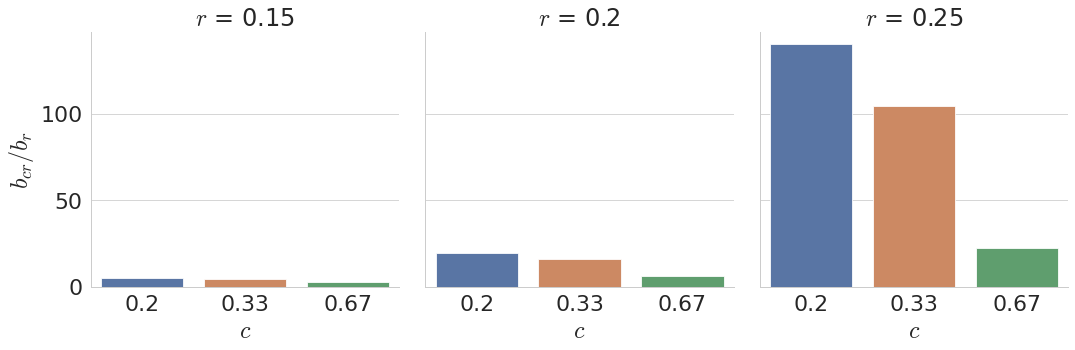

In [8]:
ratio_plot("movielens", jaccard, (0.15, 0.2, 0.25), (2/3, 1/3, 1/5))

downloading http://itu.dk/people/maau/fairnn/datasets/sift-128-euclidean.pickle -> data/sift-128-euclidean.pickle...


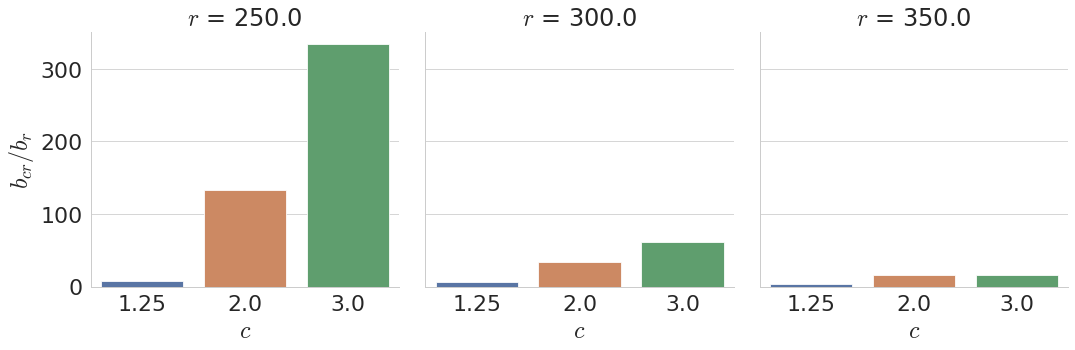

In [9]:
ratio_plot("sift-128-euclidean", l2, (250, 300, 350), (1.25, 2, 3))

downloading http://itu.dk/people/maau/fairnn/datasets/glove-100-angular.pickle -> data/glove-100-angular.pickle...


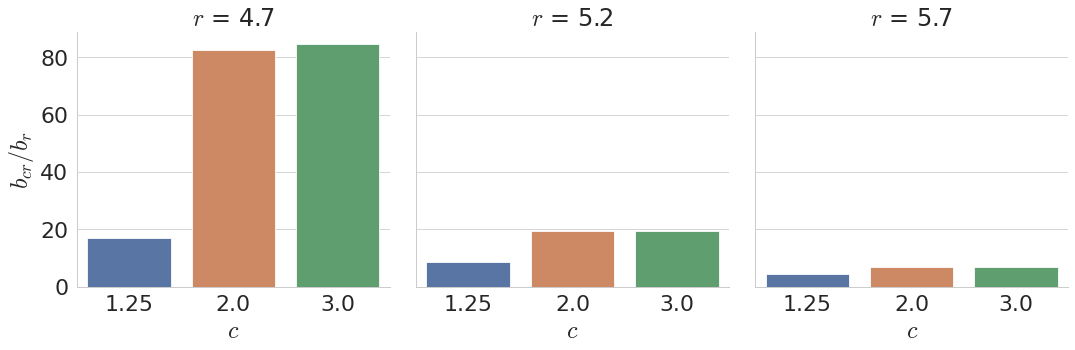

In [10]:
ratio_plot("glove-100-angular", l2, (4.7, 5.2, 5.7), (1.25, 2, 3))

downloading http://itu.dk/people/maau/fairnn/datasets/mnist-784-euclidean.pickle -> data/mnist-784-euclidean.pickle...


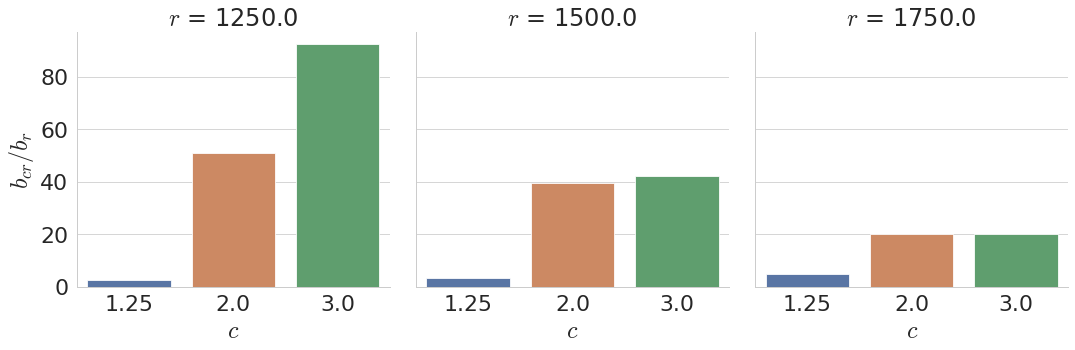

In [11]:
ratio_plot("mnist-784-euclidean", l2, (1250, 1500, 1750), (1.25, 2, 3))

# Fairness of the output

Produce plots that show individual fairness of the output

In [9]:
def produce_distribution_plot(dd, ds, distance_f, r, scale=5):
    import pickle
    plt.rcParams["figure.figsize"] =(20,10)
    sns.set_context('paper', font_scale=3.5)

    df_dict = {
        "query": [],
        "point": [],
        "freq": [],
        "sim": []
    }

    data, queries, _, _ = get_dataset(ds)

    for i, q in enumerate(dd):
        for point, count in dd[q].items():
            df_dict["query"].append(i) 
            df_dict["point"].append(point) 
            df_dict["freq"].append(count) 
            df_dict["sim"].append(distance_f(queries[q], data[point]))
    df = pd.DataFrame(data=df_dict)


    cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

    if distance_f == l2:
        df = df[df.sim <= r]
    if distance_f == jaccard:
        df = df[df.sim >= r]
    df = df.groupby(['query', 'sim']).mean().reset_index()

    
    norms = df.groupby(['query']).sum().reset_index()[['query', 'freq']]
    norms = norms.rename (columns={'freq' : 'norm'})
    df = df.merge(norms, left_on='query', right_on='query')
    #df['relfreq'] = df[['freq', 'norm']].apply(lambda x: x[0] / x[1], axis=1)
    #max_size = max(df.relfreq.values)
    ax = sns.scatterplot(data=df[df.freq < 0].rename(
                columns={'query' : 'Query', 
                        #'relfreq' : 'rel freq', 
                        'freq' : 'freq', 
                        'sim' : 'Similarity'}), 
                x='Similarity', y = 'Query', 
                hue='freq',
                size='freq', 
                sizes = (50 * scale, 50 * scale),
                palette=sns.color_palette("dark:salmon_r", as_cmap=True)


                )   

    sns.scatterplot(ax=ax, data=df[df.freq >= 0].rename(
                columns={'query' : 'Query', 
                        #'relfreq' : 'rel freq', 
                        'freq' : 'freq', 
                        'sim' : 'Similarity'}), 
                x='Similarity', y = 'Query', 
                hue='freq',
                size='freq', 
                sizes = (60 * scale, 500 * scale),
                palette=cmap
                )   
    
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    leg = plt.legend()
    for t in leg.texts:
    # truncate label text to 4 characters
        t.set_text(t.get_text()[:4])
    #print(df)
    plt.savefig("plots/lastfm_detail.pdf")
    
    

In [10]:
def get_interesting_queries(res, ):
    query_prob = 1/numpy.array(res["candidates"])
    _, details = total_variation_dist(query_prob, result_prob(res["res"]))
    queries = list(enumerate(details))
    queries.sort(key=lambda x:-x[1])
    return [i for i, q in queries[:5]]

avg. sim (biased): 0.31128584969809886
avg. sim (debiased): 0.26981508840266144


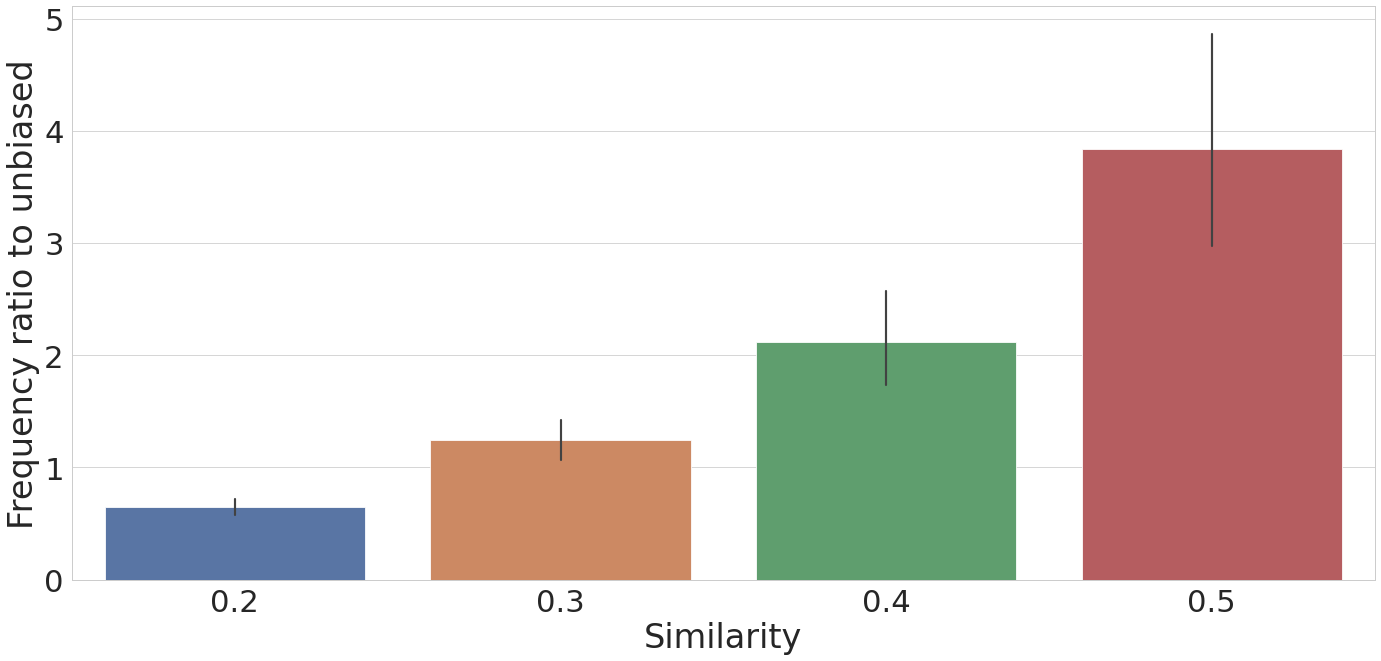

In [14]:
import pickle
import collections

ds = "lastfm"
k = 8
L = 300
w = 3700
method = "onebitminhash"

fn = f"python/results/{ds}/uniform/{method}/k_{k}_L_{L}.pickle"
gn = f"python/results/{ds}/opt/{method}/k_{k}_L_{L}.pickle"
with open(fn, 'rb') as f:
    res = pickle.load(f)

with open(gn, 'rb') as g:
    res2 = pickle.load(g)

query = 8

interesting_queries = [query] # analysis below shows that this is an interesting query

uniform_point = {}
opt_point = {}
diff = {}

for q in interesting_queries:
    points = res["res"][q]
    uniform_point[q] = collections.Counter(points)
    opt_point[q] = collections.Counter(res2["res"][q])

for q in interesting_queries:
    for p, cnt in uniform_point[q].items():
        diff.setdefault(q, {})
        diff[q][p] = cnt / opt_point[q][p]


diff = diff[q]

diff_with_sim = {}

data, queries, _, _ = get_dataset("lastfm")

for p, c in diff.items():
    diff_with_sim[p] = (c, jaccard(data[p], queries[q]))

# average with standard
s = 0
for p, cnt in uniform_point[q].items():
    jj = jaccard(data[p], queries[q])  
    s += cnt * jj
print(f"avg. sim (biased): {s / len(res['res'][q])}")

# average with opt
s = 0
for p, cnt in opt_point[q].items():
    s += cnt * jaccard(data[p], queries[q])
print(f"avg. sim (debiased): {s / len(res['res'][q])}")

df_dict = {
    "freq": [],
    "sim": []
}


for p, (cnt, sim) in diff_with_sim.items():
        df_dict["freq"].append(cnt) 
        df_dict["sim"].append(float("%.1f" % sim))
df = pd.DataFrame(data=df_dict)
sns.barplot(data=df.rename(columns={"freq" : "Frequency ratio to unbiased", "sim" : "Similarity"}), x='Similarity', y='Frequency ratio to unbiased')
plt.tight_layout()
plt.savefig("plots/sampling_differences_lastfm.pdf")





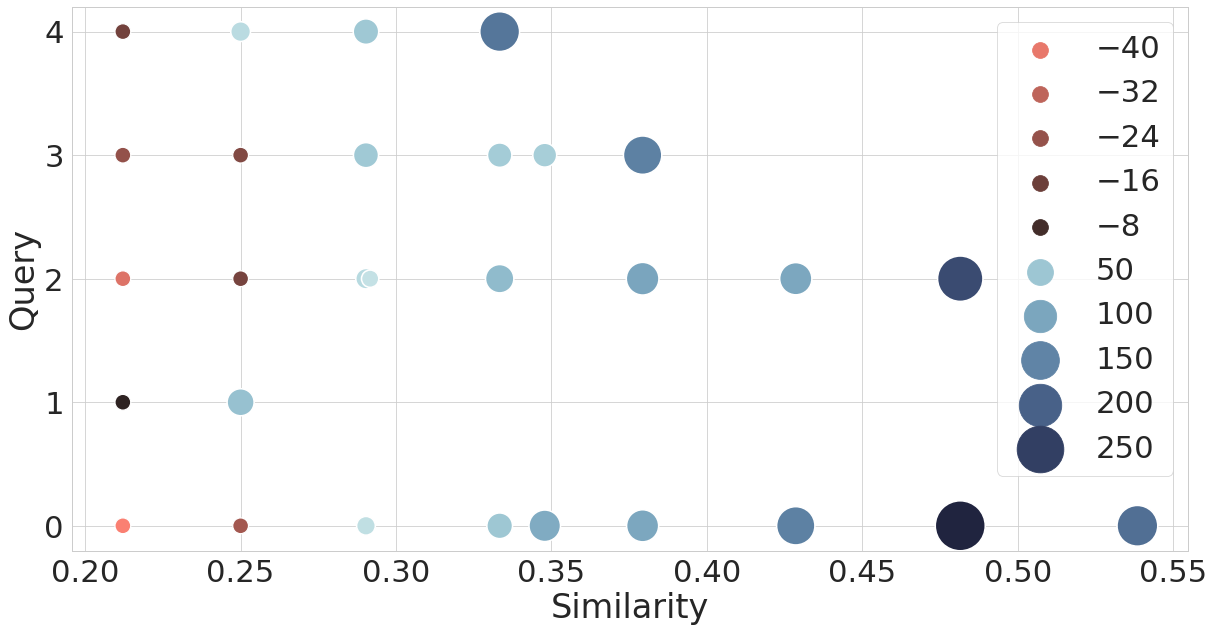

In [11]:
import pickle
import collections

ds = "lastfm"
k = 8
L = 300
w = 3700
method = "onebitminhash"

fn = f"python/results/{ds}/uniform/{method}/k_{k}_L_{L}.pickle"
gn = f"python/results/{ds}/opt/{method}/k_{k}_L_{L}.pickle"
with open(fn, 'rb') as f:
    res = pickle.load(f)

with open(gn, 'rb') as g:
    res2 = pickle.load(g)
interesting_queries = get_interesting_queries(res)

uniform_point = {}
opt_point = {}
diff = {}

for q in interesting_queries:
    points = res["res"][q]
    uniform_point[q] = collections.Counter(points)
    opt_point[q] = collections.Counter(res2["res"][q])

for q in interesting_queries:
    for p, cnt in uniform_point[q].items():
        #print(q, p, cnt)
        diff.setdefault(q, {})
        diff[q][p] = cnt - opt_point[q][p]


produce_distribution_plot(diff, res["dataset"], distance_f=jaccard, r=0.2)

#produce_distribution_plot(fn, distance_f=jaccard, r=0.2, interesting_queries=interesting_queries)
#plt.show()
#produce_distribution_plot(gn, distance_f=jaccard, r=0.2, interesting_queries=interesting_queries)

# Discussion: Approximate neighborhood is unfair?

,point,count,runs,sim,prob
0,987,258,10000,0.9,0.0258
1,988,6,10000,0.6,0.0006
2,989,150,10000,0.5,0.0150


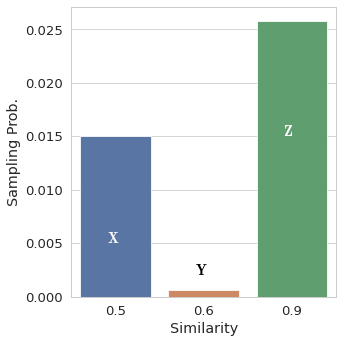

In [2]:
# Just run the experiment in here
import os

if not os.path.isfile("exp-res/approx.csv"):
    import approx_exp
    approx_exp.run("exp-res/approx.csv")

plt.rcParams["figure.figsize"] =(5,5)
sns.set_context('paper', font_scale=1.5)

df = pd.read_csv("exp-res/approx.csv")
df['sim'] = [0.9, 0.6, 0.5]
df['prob'] = df[['count', 'runs']].apply(lambda x: x[0] / x[1], axis=1)

ax = sns.barplot(data=df.rename(columns={'sim': 'Similarity', 'prob' : 'Sampling Prob.'}), x='Similarity', y='Sampling Prob.')
ax.text(-0.1, 0.005, "$\mathbf{X}$", horizontalalignment='left', size='medium', color='white', weight='semibold')
ax.text(1.9, 0.015, "$\mathbf{Z}$", horizontalalignment='left', size='medium', color='white', weight='semibold')
ax.text(0.9, 0.002, "$\mathbf{Y}$", horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.tight_layout()
plt.savefig("plots/sampling_prob.pdf")

df




# Running time experiments

In [21]:
import glob
df = pd.DataFrame(columns=["dataset", "method", "tvd", "time", "avg_degree", "max_degree"])

plt.rcParams["figure.figsize"] =(30,10)
sns.set_context('paper', font_scale=2.5)

for csv in glob.glob("exp-res/*L=100*.out"):
    tmp_df = pd.read_csv(csv, names=["method", "tvd", "time", "non_near", "rejections", "avg_degree", "max_degree"])
    tmp_df['dataset'] = csv.split("/")[-1].split("_")[0]
    df = df.sort_values(by=['dataset']).append(tmp_df)
    
    df['dataset'].replace({
        "glove-100-angular-data" : "GLOVE (L=100)",
        "sift-128-euclidean-data" : "SIFT (L=100)", 
        "mnist-784-euclidean-data" : "MNIST (L=100)"
    }, inplace=True)

for csv in glob.glob("exp-res/*L=300*.out"):
    tmp_df = pd.read_csv(csv, names=["method", "tvd", "time", "non_near", "rejections", "avg_degree", "max_degree"])
    tmp_df['dataset'] = csv.split("/")[-1].split("_")[0]
    df = df.sort_values(by=['dataset']).append(tmp_df)
    df['dataset'].replace({
        "glove-100-angular-data" : "GLOVE (L=300)",
        "sift-128-euclidean-data" : "SIFT (L=300)", 
        "mnist-784-euclidean-data" : "MNIST (L=300)"
    }, inplace=True)

df['method'].replace({
    0 : "uniform",
    1 : "weighted uniform",
    2 : "exact degree",
    3 : "approx. degree",
    4 : "rank",
    7 : "collect"}, inplace=True)



print(df[(df.method !=5) & (df.method != 6)].sort_values(by=['method', 'dataset'])[['method', 'dataset', 'time', 'avg_degree', 'max_degree', 'non_near', 'rejections']].to_latex(index=False,  float_format="%.3f" ))

\begin{tabular}{llrrrrr}
\toprule
           method &        dataset &   time &  avg\_degree &  max\_degree &  non\_near &  rejections \\
\midrule
   approx. degree &  GLOVE (L=100) &  0.013 &       1.800 &       5.600 &     4.460 &       0.326 \\
   approx. degree &  GLOVE (L=300) &  0.090 &       5.480 &      14.060 &    11.700 &       4.144 \\
   approx. degree &  MNIST (L=100) &  0.026 &       2.540 &      12.280 &     0.120 &       1.810 \\
   approx. degree &  MNIST (L=300) &  0.125 &       7.760 &      35.560 &     1.060 &       6.704 \\
   approx. degree &   SIFT (L=100) &  0.006 &       2.180 &       8.280 &     0.540 &       1.360 \\
   approx. degree &   SIFT (L=300) &  0.031 &       6.220 &      20.940 &     1.840 &       5.156 \\
          collect &  GLOVE (L=100) &  8.104 &       1.800 &       5.600 &     0.000 &       0.000 \\
          collect &  GLOVE (L=300) & 29.307 &       5.480 &      14.060 &     0.000 &       0.000 \\
          collect &  MNIST (L=100) &  3.016 &

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]


<Figure size 2160x720 with 0 Axes>

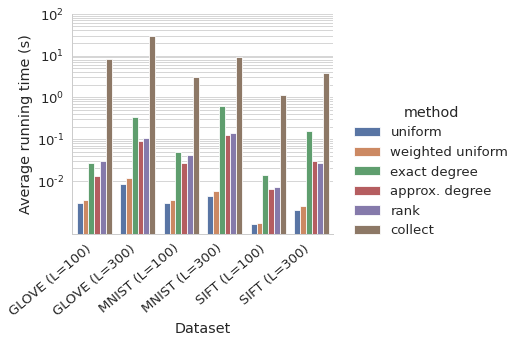

In [45]:
plt.clf()
sns.set_context('paper', font_scale=1.5)
plt.rcParams["figure.figsize"] =(20,10)
ticks = [0.01]
delta = 0.01
for i in range(4):
	for k in range(9):
		ticks.append(round(ticks[-1] + delta, 2))
	delta *= 10

print(ticks)
#ticks = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0]
g = sns.catplot(data=df[(df.method != 5) & (df.method != 6)][['method', 'time', 'dataset']], x="dataset", y="time", hue="method", kind="bar")
g.set_axis_labels("Dataset", "Average running time (s)")
g.set_xticklabels(g.ax.get_xticklabels(), rotation=40, ha="right")
plt.yscale('log')
#g.ax.minorticks_on()
#g.ax.grid(which='minor', linestyle=':', linewidth=0.3, color='black')
g.set(yticks = ticks)
g.tight_layout()
plt.savefig('plots/running_time.pdf')

In [21]:
import glob
df = pd.DataFrame(columns=["dataset", "method", "tvd", "time"])

plt.rcParams["figure.figsize"] =(30,10)
sns.set_context('paper', font_scale=2.5)

for csv in glob.glob("exp-res/*L=300*.out"):
    tmp_df = pd.read_csv(csv, names=["method", "tvd", "time", "non_near", "rejections", "avg_degree", "max_degree"])
    tmp_df['dataset'] = csv.split("/")[-1].split("_")[0]
    df = df.sort_values(by=['dataset']).append(tmp_df).replace({
        0 : "uniform",
        1 : "weighted uniform",
        2 : "exact degree",
        3 : "approx. degree",
        4 : "rank",
        7 : "collect",
        "glove-100-angular-data" : "GLOVE",
        "sift-128-euclidean-data" : "SIFT", 
        "mnist-784-euclidean-data" : "MNIST"
    })

df

,dataset,method,tvd,time,non_near,rejections,avg_degree,max_degree
0,GLOVE,uniform,0.304632,0.008400,6.67,uniform,5.48,14.06
1,GLOVE,weighted uniform,0.254872,0.011851,11.68,uniform,5.48,14.06
2,GLOVE,exact degree,0.25,0.340203,11.7,4.434,5.48,14.06
3,GLOVE,approx. degree,0.250612,0.090433,11.7,4.144,5.48,14.06
4,GLOVE,rank,0.25,0.108483,7.16,uniform,5.48,14.06
5,GLOVE,5,-nan,0.005078,uniform,uniform,5.48,14.06
6,GLOVE,6,-nan,0.004075,uniform,uniform,5.48,14.06
7,GLOVE,collect,0.25,29.307000,uniform,uniform,5.48,14.06
0,MNIST,uniform,0.323077,0.004377,0.542,uniform,7.76,35.56
1,MNIST,weighted uniform,0.282546,0.005652,1.044,uniform,7.76,35.56


[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]


<Figure size 2160x720 with 0 Axes>

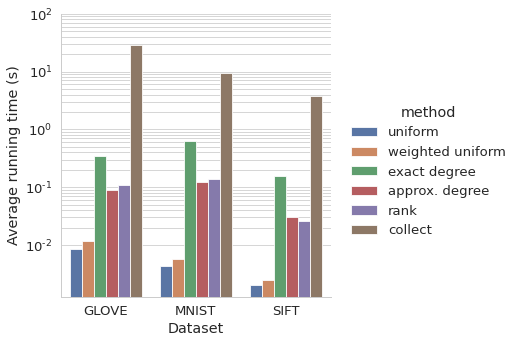

In [23]:
plt.clf()
sns.set_context('paper', font_scale=1.5)
ticks = [0.01]
delta = 0.01
for i in range(4):
	for k in range(9):
		ticks.append(round(ticks[-1] + delta, 2))
	delta *= 10

print(ticks)
#ticks = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0]
g = sns.catplot(data=df[(df.method != 5) & (df.method != 6)][['method', 'time', 'dataset']], x="dataset", y="time", hue="method", kind="bar")
g.set_axis_labels("Dataset", "Average running time (s)")
plt.yscale('log')
#g.ax.minorticks_on()
#g.ax.grid(which='minor', linestyle=':', linewidth=0.3, color='black')
g.set(yticks = ticks)
g.tight_layout()
plt.savefig('plots/running_time_L=300.pdf')